# Coursera Capstone - Segmenting and Clustering Neighborhoods in Toronto

## Part 1 - Read the data from the Toronto Open Data dataset

#### 1/ Imports

In [ ]:
import pandas as pd
import numpy as np

# Import Geocoder to get each area's coordinates
!conda install -c conda-forge geocoder             #Uncomment this if geocoder is not installed on your system
import geocoder # import geocoder

# Import k-means for clustering stage
from sklearn.cluster import KMeans
# MinMaxScaler for normalization : to find the best K for K-Means
from sklearn.preprocessing import MinMaxScaler

# Import Folium to draw maps
!conda install -c conda-forge folium                #Uncomment this if folium is not installed on your system
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Import Requests for querying FoursquareAPI
import requests

Solving environment: \ 

#### 2/ Consts and globals

In [2]:
# Demographic data of Toronto's areas
CONST_demographicDataLink = "https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv"

FoursquareAPI credentials

In [3]:
##Utilizing the Foursquare API to explore and segment neighborhoods
CLIENT_ID = 2GFKIZFPHZMTSMVADOZIQK2SHKOMAFGOBFL03UPJAFI1VU4C # your Foursquare ID
CLIENT_SECRET = HTHH43W3AKEFZH5XDJKZC0YXMQ0DH34HB5CJPT0IJZLEAIWF # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
# Size of the radius to retrieve venues from FoursquareAPI, and limit of venues per neighbourhood
CONST_venuesRadiusScan = 1000
CONST_venuesLimit = 1000

#### 3/ Read the demographic data

In [4]:
df_raw = pd.read_csv(CONST_demographicDataLink, encoding = "cp1252", thousands=',')

a/ Read city areas data - Key : **CDN (Numero of area)** x **City_Area (Name of area)**

In [5]:
# Get only data about areas information : filter on Characteristic
df_cityAreas = df_raw[df_raw.Characteristic == "Neighbourhood Number"]

# Drop the useless columns, only keep CDN x City_Area
df_cityAreas = df_cityAreas.drop(df_cityAreas.columns[[0,1,2,3,4]], axis=1)

# Format the dataframe
df_cityAreas = df_cityAreas.transpose()
df_cityAreas = df_cityAreas.reset_index()
df_cityAreas = df_cityAreas.iloc[:, ::-1]
df_cityAreas.columns = ['CDN', 'City_Area']
df_cityAreas.head()

,CDN,City_Area
0,129,Agincourt North
1,128,Agincourt South-Malvern West
2,20,Alderwood
3,95,Annex
4,42,Banbury-Don Mills


b/ Read demographic data by city area

In [6]:
# This function will count the leading space so we will know the data structure tree
def countLeadingSpaces(str):
    return len(str) - len(str.lstrip())

In [7]:
df_demographic = df_raw.apply(lambda x: x.str.replace(',',''))

# Filter on Topic = 'Ethnic origin population' to retrieve data about ethnic origins only
df_demographic = df_demographic[df_demographic.Topic == 'Ethnic origin population']

# Calculate the depth of Ethnic origin
df_demographic['Depth'] = df_demographic['Characteristic']

for index, row in df_demographic.iterrows():
    # The depth of Ethnic origin is calculated using the leading spaces in the data
    row['Depth'] = countLeadingSpaces(row['Depth'])

# Find each depth level of Ethnic origin, so we will be able to only keep the deepest levels
df_demographic['newLevel'] = np.where((df_demographic['Depth'].shift(+1) > df_demographic['Depth']),"new","")
    
# Reverse the dataframe
df_demographic = df_demographic.iloc[::-1]

Retrieve only the **deepest levels of data**  
For example, if we have the following data :
- x Asian origins : 1,079,290  
- xxx East and Southeast Asian origins : 586,515  
- xxxxx Chinese : 332,830  
- xxxxx Japanese : 17,265  
- etc

We will only keep **Chinese** and **Japanese**, because they are the deepest levels of Ethnic origin data, as they are parts of **East and Southeast Asian origins**, which is part of **Asian origins**. We don't want overlapping Ethnic origin data as they would make the clustering more difficult.

In [8]:
# Keep value will tell us if we need to keep the row (deepest level) or if we need to drop it
df_demographic['Keep'] = 0
tmpDepth = ""

# Loop through each row
for index, row in df_demographic.iterrows():
    # We keep the first element, because the dataframe has been reversed so the first row is a deepest level
    if tmpDepth == "":
        df_demographic.loc[index, 'Keep'] = 1
        
        # We keep the current level of depth in a temp variable, so we will be able to compare it in the next row iterration
        tmpDepth = row['Depth']
    
    else:
        # If the depth level of the previous row equals the depth level of the current row : same depth, so we keep the row
        if tmpDepth == row['Depth']:
            df_demographic.loc[index, 'Keep'] = 1
        
        # New level : we reset the temp variable
        elif row['newLevel'] == "new":
            # Reset tmpDepth
            tmpDepth = ""
            
# Reverse the dataframe
df_demographic = df_demographic.iloc[::-1]

# Keep only the necessary rows
df_demographic = df_demographic[df_demographic.Keep == 1]

# Drop the useless columns
df_demographic = df_demographic.drop(['Depth', 'newLevel', 'Keep'], 1)
df_demographic.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1348,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,First Nations (North American Indian),27610,25,90,200,345,175,...,60,110,470,355,235,275,90,130,200,85
1349,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Inuit,515,0,0,15,20,10,...,0,0,25,0,0,10,0,0,0,0
1350,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Métis,8465,10,25,100,115,60,...,40,35,110,80,60,80,45,75,40,10
1352,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Acadian,2315,20,0,10,60,0,...,0,0,10,45,20,30,10,0,10,0
1353,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,American,27470,40,70,100,705,325,...,155,145,140,275,95,275,320,280,175,100


In [9]:
# Drop the useless columns
df_demographic.drop(df_demographic.columns[[0, 1, 2, 4]], axis=1, inplace=True)
df_demographic.rename(columns={'Characteristic':''}, inplace=True)

# Put the city areas names as the dataframe columns
df_demographic = df_demographic.transpose()
df_demographic.columns = df_demographic.iloc[0]
df_demographic = df_demographic.iloc[1:]

# Drop the Total column as we won't use it
df_demographic.drop(df_demographic.columns[[0]], axis=1, inplace=True)

# Format the dataframe
df_demographic = df_demographic.reset_index()
df_demographic.rename(columns={'index':'City_Area'}, inplace=True)
df_demographic.head()

,City_Area,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,Agincourt North,0,10,20,40,1295,0,10,0,0,...,0,320,20,135,0,0,0,0,0,0
1,Agincourt South-Malvern West,0,25,0,70,1125,0,0,0,0,...,0,180,10,55,0,0,0,0,0,0
2,Alderwood,15,100,10,100,2245,0,15,0,0,...,110,45,0,0,0,0,0,0,0,0
3,Annex,20,115,60,705,4655,0,10,10,0,...,0,145,15,25,0,0,10,0,0,10
4,Banbury-Don Mills,10,60,0,325,3035,0,0,10,0,...,0,115,0,45,0,0,10,0,0,0


## Part 2 - Add the latitude and the longitude coordinates of each city area

#### 2/ Get all coordinates by postal code, using geocoder with arcgis

In [10]:
# This function returns the latitude and longitude of the given postal code, in Toronto
def getCoordsByCityArea(area):
    # initialize to None : this variable will allow us to loop until geocoder responds with the coordinates
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(area))
        lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    return latitude, longitude

In [11]:
areasWithCoordsList = []

# Loop through each postal code from our dataframe
for area in df_cityAreas['City_Area']:
    # Fill the temp list with the coordinates from geocoder
    latitude, longitude = getCoordsByCityArea(area)
    areasWithCoordsList.append([area, latitude, longitude])
    
# Transform the temp list into a dataframe
df_coords = pd.DataFrame(areasWithCoordsList)
df_coords.columns = ['City_Area', 'Latitude', 'Longitude']

# Merge the coordinates dataframe with the original neighbourhoods dataframe (key : postal code)
df_cityAreas = pd.merge(df_cityAreas, df_coords, on='City_Area')
df_cityAreas.head()

,CDN,City_Area,Latitude,Longitude
0,129,Agincourt North,43.80930,-79.26707
1,128,Agincourt South-Malvern West,43.78735,-79.26941
2,20,Alderwood,43.60496,-79.54116
3,95,Annex,43.66936,-79.40280
4,42,Banbury-Don Mills,43.74041,-79.34852


## Part 3 - Neighbourhoods clustering using ethnic origins

#### 2/ Generate the map of Toronto with the neighbourhoods

Retrieve the coordinates of the city of Toronto so we can draw it using Folium

In [12]:
address = 'Toronto, ON'

# initialize to None
lat_lng_coords = None

# loop until we get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('Toronto, Ontario')
    lat_lng_coords = g.latlng

latitude_toronto = lat_lng_coords[0]
longitude_toronto = lat_lng_coords[1]

print('The geographical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geographical coordinate of Toronto are 43.648690000000045, -79.38543999999996.


We can draw the city of Toronto with the neighbourhoods from the dataframe

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, CDN, City_Area in zip(df_cityAreas['Latitude'], df_cityAreas['Longitude'], df_cityAreas['CDN'], df_cityAreas['City_Area']):
    label = '{} - {}'.format(CDN, City_Area)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto) 
    
map_toronto

Print each neighborhood along with the top 10 most common ethnic origins

In [14]:
num_top = 10

# Iterate through all the dataframe
for index, row in df_demographic.iterrows():
    tempArea = row['City_Area']
    
    print("----"+tempArea+"----")
    
    # Create a temp df filtered on the current neighbourhood (key : City_Area)
    temp = df_demographic[
        (df_demographic.City_Area == tempArea)
    ].T.reset_index()
    
    temp.columns = ['Origin','Count']

    # We skip the key PostalCode x Borough x Neighbourhood : length = 3, iloc[3:]
    temp = temp.iloc[1:]
    temp['Count'] = temp['Count'].astype(float)
    
    # Round the frequency with two digits
    temp = temp.round({'Count': 2})
    
    print(temp.sort_values('Count', ascending=False).reset_index(drop=True).head(num_top))
    print('\n')

----Agincourt North----
              Origin    Count
0            Chinese  16950.0
1         Sri Lankan   2230.0
2        East Indian   2090.0
3           Filipino   1465.0
4           Canadian   1295.0
5            English    870.0
6              Tamil    855.0
7           Jamaican    780.0
8           Scottish    600.0
9              Irish    425.0


----Agincourt South-Malvern West----
              Origin    Count
0            Chinese  11455.0
1        East Indian   2180.0
2           Filipino   1405.0
3         Sri Lankan   1145.0
4           Canadian   1125.0
5            English    985.0
6           Scottish    725.0
7           Jamaican    645.0
8            Italian    630.0
9              Irish    620.0


----Alderwood----
             Origin   Count
0           English  2320.0
1          Canadian  2245.0
2             Irish  1900.0
3          Scottish  1720.0
4           Italian  1275.0
5            Polish  1225.0
6            German   940.0
7            French   850.0
8    

#### 4/ Put the results into a Pandas dataframe

Function to sort the venues in descending order.

In [15]:
def return_most_common_ethn(row, num_top):
    # Remove the key from the row
    row_categories = row.iloc[1:].astype(float)
    
    # Sort ascending
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # Return the top num_top_venues
    return row_categories_sorted.index.values[0:num_top]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [16]:
num_top = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City_Area']

for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Origin'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Origin'.format(ind+1))

# create a new dataframe, and set it with the columns names
areas_ethn_sorted = pd.DataFrame(columns=columns)

# add the keys from the grouped dataframe (City_Area)
areas_ethn_sorted['City_Area'] = df_demographic['City_Area']

# loop through each rows
for ind in np.arange(df_demographic.shape[0]):
    areas_ethn_sorted.iloc[ind, 1:] = return_most_common_ethn(df_demographic.iloc[ind, :], num_top)

areas_ethn_sorted.head()

,City_Area,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,Agincourt North,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,Agincourt South-Malvern West,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,Alderwood,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,Annex,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,Banbury-Don Mills,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French


#### 5/ Cluster areas

In [17]:
toronto_areas_clustering = df_demographic.drop('City_Area', 1)

data = toronto_areas_clustering.astype(float)

data.head()

,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,Québécois,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,0.0,10.0,20.0,40.0,1295.0,0.0,10.0,0.0,0.0,0.0,...,0.0,320.0,20.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,25.0,0.0,70.0,1125.0,0.0,0.0,0.0,0.0,0.0,...,0.0,180.0,10.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.0,100.0,10.0,100.0,2245.0,0.0,15.0,0.0,0.0,20.0,...,110.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.0,115.0,60.0,705.0,4655.0,0.0,10.0,10.0,0.0,15.0,...,0.0,145.0,15.0,25.0,0.0,0.0,10.0,0.0,0.0,10.0
4,10.0,60.0,0.0,325.0,3035.0,0.0,0.0,10.0,0.0,15.0,...,0.0,115.0,0.0,45.0,0.0,0.0,10.0,0.0,0.0,0.0


Normalize data

In [18]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

pd.DataFrame(data_transformed).head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.000000,0.032787,0.235294,0.048193,0.088448,0.0,0.153846,0.0,0.0,0.0,...,0.000000,0.089261,0.266667,0.482143,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.081967,0.000000,0.084337,0.067990,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.050209,0.133333,0.196429,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.500000,0.327869,0.117647,0.120482,0.202768,0.0,0.230769,0.0,0.0,0.4,...,0.057292,0.012552,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.666667,0.377049,0.705882,0.849398,0.492780,0.0,0.153846,0.5,0.0,0.3,...,0.000000,0.040446,0.200000,0.089286,0.0,0.0,0.4,0.0,0.0,0.333333
4,0.333333,0.196721,0.000000,0.391566,0.297834,0.0,0.000000,0.5,0.0,0.3,...,0.000000,0.032078,0.000000,0.160714,0.0,0.0,0.4,0.0,0.0,0.000000


Elbow method - To find the best number of clusters K

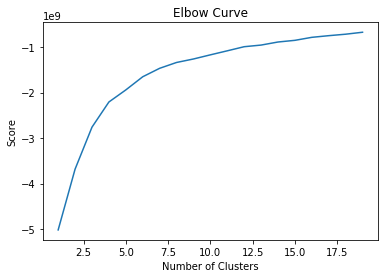

In [19]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

We can see that the elbow is at K = 5, so we are going to use K = 5

In [20]:
# set number of clusters
kclusters = 5

toronto_areas_clustering = df_demographic.drop('City_Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 0, 4, 1, 0, 1, 1, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [21]:
# add clustering labels
areas_ethn_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [22]:
toronto_merged = df_cityAreas

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(areas_ethn_sorted.set_index(['City_Area']), on=['City_Area'])

toronto_merged.head() # check the last columns!

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78735,-79.26941,3,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,20,Alderwood,43.60496,-79.54116,0,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,95,Annex,43.66936,-79.40280,4,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French


Visualise the clusters

In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cityArea, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['City_Area'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(cityArea) + ' - Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 6/ Examine clusters

**Cluster 0** regroups areas higly habited by **European and Canadian people**.  
We can see **English, Italian, Portuguese, French people** ...  
These clusters are represented by red circles on the map. We can see that most of them are positioned in almost all the south of Toronto, and in the downtown.  

In [24]:
toronto_merged[toronto_merged['Cluster Labels'] == 0].head(50)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
2,20,Alderwood,43.604960,-79.541160,0,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
5,34,Bathurst Manor,43.763780,-79.454770,0,Filipino,Russian,Italian,Polish,Canadian,Jewish,Chinese,English,Ukrainian,Greek
9,39,Bedford Park-Nortown,43.730660,-79.424500,0,Canadian,Polish,English,Russian,Scottish,Irish,Filipino,Jewish,German,Italian
10,112,Beechborough-Greenbrook,43.693110,-79.478310,0,Portuguese,Jamaican,Italian,Canadian,Filipino,East Indian,English,Spanish,Vietnamese,Other African origins; n.i.e.
13,24,Black Creek,43.766360,-79.521500,0,Vietnamese,Jamaican,Canadian,Italian,East Indian,Chinese,Filipino,Iraqi,Ghanaian,Other African origins; n.i.e.
14,69,Blake-Jones,43.675220,-79.337620,0,English,Canadian,Irish,Scottish,Chinese,French,German,Greek,East Indian,Jamaican
15,108,Briar Hill-Belgravia,43.698520,-79.451250,0,Filipino,Italian,Portuguese,Canadian,English,Scottish,Irish,Albanian,Russian,Polish
16,41,Bridle Path-Sunnybrook-York Mills,43.727320,-79.380810,0,English,Scottish,Canadian,Chinese,Irish,Italian,German,French,Russian,Polish
17,57,Broadview North,43.689370,-79.354290,0,English,Irish,Scottish,Greek,Canadian,French,German,Chinese,Filipino,Serbian
18,30,Brookhaven-Amesbury,43.700310,-79.484650,0,Italian,Portuguese,Jamaican,Canadian,Filipino,Vietnamese,Chinese,Other African origins; n.i.e.,English,East Indian


**Cluster 1** regroups areas higly habited by **Chinese people, and people from others countries in Asia**.  
These are represented by violet circles on the map. We can see that most of them are positioned at the north of Toronto.  

In [25]:
toronto_merged[toronto_merged['Cluster Labels'] == 1].head(50)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.38220,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French
30,47,Don Valley Village,43.78552,-79.35017,1,Chinese,Filipino,East Indian,Iranian,English,Canadian,Irish,Scottish,Korean,Armenian
31,126,Dorset Park,43.75533,-79.27746,1,Filipino,East Indian,Chinese,Canadian,Sri Lankan,English,Jamaican,Scottish,Tamil,Irish
48,53,Henry Farm,43.77230,-79.34087,1,Chinese,East Indian,Filipino,Iranian,Canadian,English,Scottish,Irish,Afghan,Korean
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian,Iranian,Korean,English,Russian,Scottish,Polish,Irish
62,78,Kensington-Chinatown,43.65331,-79.39634,1,Chinese,Canadian,English,Irish,Scottish,French,German,Italian,Polish,East Indian


**Cluster 2** concentrates areas haghly habited by **Indian people**.  
These clusters are represented by dark green. We can see that these areas are located at the edges of Toronto.

In [26]:
toronto_merged[toronto_merged['Cluster Labels'] == 2].head(10)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
73,132,Malvern,43.80977,-79.22084,2,East Indian,Sri Lankan,Filipino,Chinese,Jamaican,Canadian,English,Tamil,Guyanese,Pakistani
81,2,Mount Olive-Silverstone-Jamestown,43.74721,-79.58826,2,East Indian,Iraqi,Jamaican,Canadian,Somali,Italian,Assyrian,Sri Lankan,Other African origins; n.i.e.,Ghanaian
105,131,Rouge,43.80766,-79.17405,2,East Indian,Sri Lankan,Canadian,Filipino,Jamaican,English,Chinese,Tamil,Scottish,Irish
124,1,West Humber-Clairville,43.71451,-79.59292,2,East Indian,Jamaican,Canadian,Filipino,Italian,Punjabi,English,Guyanese,Chinese,Scottish
132,137,Woburn,43.76730,-79.22823,2,East Indian,Canadian,Sri Lankan,Chinese,Filipino,English,Irish,Scottish,Jamaican,Tamil


**Cluster 3** also regroups areas higly habited by **asian people, the most common ethnic origin is Chinese**.  
These are represented by light green circles on the map. We can see that most of them are positioned at the north east of Toronto, next to the cluster 1.

In [27]:
toronto_merged[toronto_merged['Cluster Labels'] == 3].head(10)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78735,-79.26941,3,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
66,117,L'Amoreaux,43.79726,-79.31220,3,Chinese,East Indian,Canadian,Sri Lankan,Filipino,English,Armenian,Jamaican,Scottish,Irish
76,130,Milliken,43.82280,-79.27694,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,Tamil,Jamaican,English,Vietnamese,Spanish
112,116,Steeles,43.81219,-79.32128,3,Chinese,East Indian,Canadian,Filipino,English,Greek,Italian,Scottish,Sri Lankan,Egyptian
129,51,Willowdale East,43.77248,-79.40039,3,Chinese,Iranian,Korean,East Indian,English,Canadian,Scottish,Irish,Russian,Italian


**Cluster 4** regroups areas higly habited by **English, Irish, Scottish and Canadian** people.  
We can also see that there are a lot of people from other **european countries as well, such as French, German, Polish**, ...  
These are represented by yellow circles on the map. We can see that most of them are positioned at the south and in the downtown of Toronto.

In [28]:
toronto_merged[toronto_merged['Cluster Labels'] == 4].head(50)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
3,95,Annex,43.66936,-79.40280,4,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
12,122,Birchcliffe-Cliffside,43.69472,-79.26460,4,English,Irish,Canadian,Scottish,French,German,Chinese,Italian,Filipino,British Isles origins; n.i.e.
23,75,Church-Yonge Corridor,43.66024,-79.37868,4,English,Irish,Scottish,Chinese,Canadian,French,German,East Indian,Italian,Polish
32,93,Dovercourt-Wallace Emerson-Junction,43.66604,-79.43687,4,Portuguese,English,Canadian,Irish,Scottish,Chinese,Italian,German,French,East Indian
35,62,East End-Danforth,43.68415,-79.29911,4,English,Irish,Scottish,Canadian,French,German,Chinese,Italian,Polish,British Isles origins; n.i.e.
49,88,High Park North,43.65767,-79.46458,4,English,Irish,Scottish,Canadian,German,Polish,French,Ukrainian,Italian,Russian
50,87,High Park-Swansea,43.64704,-79.47114,4,English,Irish,Scottish,Canadian,German,Polish,French,Italian,Ukrainian,British Isles origins; n.i.e.
58,14,Islington-City Centre West,43.63608,-79.54296,4,English,Canadian,Italian,Irish,Scottish,Polish,Ukrainian,East Indian,German,Chinese
68,105,Lawrence Park North,43.72830,-79.40642,4,English,Scottish,Canadian,Irish,German,Chinese,French,Polish,Italian,Russian
69,103,Lawrence Park South,43.71853,-79.40574,4,English,Scottish,Canadian,Irish,German,Polish,Russian,French,Italian,Chinese


# Part 4 - Use cases

This function will retrieve the FoursquareAPI venues for all the neighbourhoods given in parameters

In [29]:
def getNearbyVenues(cdn, latitudes, longitudes):
    
    venues_list=[]
    # Loop through each neighbourhood given in parameters
    for cdn, lat, lng in zip(cdn, latitudes, longitudes):

        # create the API request URL to explore the neighbourhood using FoursquareAPI
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            CONST_venuesRadiusScan, 
            CONST_venuesLimit)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue : name, latitude, longitude, and the categories' names
        venues_list.append([(
            cdn,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # add the venues in the dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                        'CDN',
                        'Area Latitude', 
                        'Area Longitude', 
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category'
    ]
    
    return(nearby_venues)

#### 1/ Best spots for opening a new chinese restaurant

As we just saw, the city areas with the most concentration of chinese people are the ones which have beed categorised into the **clusters 1 and 3**.  
These clusters represent the areas at the **north east of Toronto**.  

Because there are a lot of possible neighbourhoods, we are going to use FoursquareAPI to see the number of chinese restaurants that already exist in each city area. We will assume that the areas with the fewer number of existing chinese restaurants within these clusters will represent the best areas to open a new chinese restaurant

In [30]:
toronto_chinese = toronto_merged[(toronto_merged['Cluster Labels'] == 3) | (toronto_merged['Cluster Labels'] == 1)]

toronto_chinese.head()

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78735,-79.26941,3,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish


In [31]:
# Get the venues for each neighbourhood
chinese_restaurants_venues = getNearbyVenues(  
                                    cdn=toronto_chinese['CDN'],
                                    latitudes=toronto_chinese['Latitude'],
                                    longitudes=toronto_chinese['Longitude']
                                  )

chinese_restaurants_venues[(chinese_restaurants_venues['Venue Category'] == "Chinese Restaurant")].head()

,CDN,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
8,129,43.80930,-79.26707,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
36,128,43.78735,-79.26941,Maple Yip Seafood 陸羽海鮮酒家,43.784752,-79.277787,Chinese Restaurant
38,128,43.78735,-79.26941,Asian Legend 味香村,43.788068,-79.266768,Chinese Restaurant
43,128,43.78735,-79.26941,Dumpling House 餃子莊,43.787209,-79.269909,Chinese Restaurant
45,128,43.78735,-79.26941,Perfect Chinese Restaurant 雅瓊海鮮酒家,43.787774,-79.270294,Chinese Restaurant


In [32]:
chinese_restaurants_count = chinese_restaurants_venues.groupby(['CDN','Area Latitude', 'Area Longitude']).count().reset_index()

# Drop the useless columns
chinese_restaurants_count = chinese_restaurants_count.drop(chinese_restaurants_count.columns[[1,2,3,4,5]], axis=1)
chinese_restaurants_count.columns = ['CDN', 'Count']

# Merge the counts with the toronto_chinese dataframe
toronto_chinese = toronto_chinese.join(chinese_restaurants_count.set_index(['CDN']), on=['CDN'])
toronto_chinese = toronto_chinese.sort_values(by='Count')

toronto_chinese.head(15)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin,Count
130,37,Willowdale West,43.77094,-79.42785,1,Chinese,Korean,Iranian,English,Canadian,Irish,Scottish,Russian,Italian,East Indian,5
111,40,St.Andrew-Windfields,43.75720,-79.38188,1,Chinese,English,Canadian,Iranian,Polish,Irish,Scottish,Russian,East Indian,Korean,5
8,49,Bayview Woods-Steeles,43.79485,-79.38220,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian,14
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French,16
86,36,Newtonbrook West,43.78818,-79.43173,1,Filipino,Chinese,Russian,Korean,Iranian,Jewish,Italian,Ukrainian,English,Canadian,17
98,46,Pleasant View,43.78812,-79.33453,1,Chinese,Greek,Italian,Canadian,East Indian,English,Scottish,Filipino,Irish,Iranian,18
76,130,Milliken,43.82280,-79.27694,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,Tamil,Jamaican,English,Vietnamese,Spanish,18
112,116,Steeles,43.81219,-79.32128,3,Chinese,East Indian,Canadian,Filipino,English,Greek,Italian,Scottish,Sri Lankan,Egyptian,19
129,51,Willowdale East,43.77248,-79.40039,3,Chinese,Iranian,Korean,East Indian,English,Canadian,Scottish,Irish,Russian,Italian,22
85,50,Newtonbrook East,43.79304,-79.40695,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,Italian,East Indian,Filipino,23


Draw the top 5 spots on the map

In [33]:
toronto_chinese_top = toronto_chinese.head(5)

# create map of Toronto using latitude and longitude values
spots_chinese_restaurants = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, CDN, City_Area in zip(toronto_chinese_top['Latitude'], toronto_chinese_top['Longitude'], toronto_chinese_top['CDN'], toronto_chinese_top['City_Area']):
    label = '{} - {}'.format(CDN, City_Area)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(spots_chinese_restaurants) 
    
spots_chinese_restaurants

#### 2/ Best spots for opening a new irish pub

The city areas with the most concentration of irish, scottish and english people are the ones which have beed categorised into the **clusters 4**.  
These clusters represent the areas in **the south and the downtown of Toronto**.  

Just like the chinese restaurants, we are going to use FoursquareAPI and assume that the areas with the fewer number of existing irish pubs will represent the best areas to open a new irish pub.

In [34]:
toronto_irish = toronto_merged[(toronto_merged['Cluster Labels'] == 4)]

toronto_irish.head()

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
3,95,Annex,43.66936,-79.40280,4,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
12,122,Birchcliffe-Cliffside,43.69472,-79.26460,4,English,Irish,Canadian,Scottish,French,German,Chinese,Italian,Filipino,British Isles origins; n.i.e.
23,75,Church-Yonge Corridor,43.66024,-79.37868,4,English,Irish,Scottish,Chinese,Canadian,French,German,East Indian,Italian,Polish
32,93,Dovercourt-Wallace Emerson-Junction,43.66604,-79.43687,4,Portuguese,English,Canadian,Irish,Scottish,Chinese,Italian,German,French,East Indian
35,62,East End-Danforth,43.68415,-79.29911,4,English,Irish,Scottish,Canadian,French,German,Chinese,Italian,Polish,British Isles origins; n.i.e.


In [35]:
# Get the venues for each neighbourhood
irish_pubs_venues = getNearbyVenues(  
                                    cdn=toronto_irish['CDN'],
                                    latitudes=toronto_irish['Latitude'],
                                    longitudes=toronto_irish['Longitude']
                                  )

irish_pubs_venues[(irish_pubs_venues['Venue Category'] == "Pub")].head()

,CDN,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,95,43.66936,-79.40280,The Madison Avenue Pub,43.667947,-79.403486,Pub
58,95,43.66936,-79.40280,Duke of York,43.669186,-79.397527,Pub
157,75,43.66024,-79.37868,Churchmouse & Firkin,43.664632,-79.380406,Pub
335,62,43.68415,-79.29911,Grover Pub and Grub,43.679181,-79.297215,Pub
417,88,43.65767,-79.46458,Mackenzie's High Park,43.652981,-79.468385,Pub


In [36]:
irish_pubs_count = irish_pubs_venues.groupby(['CDN','Area Latitude', 'Area Longitude']).count().reset_index()

# Drop the useless columns
irish_pubs_count = irish_pubs_count.drop(irish_pubs_count.columns[[1,2,3,4,5]], axis=1)
irish_pubs_count.columns = ['CDN', 'Count']

# Merge the counts with the toronto_chinese dataframe
toronto_irish = toronto_irish.join(irish_pubs_count.set_index(['CDN']), on=['CDN'])
toronto_irish = toronto_irish.sort_values(by='Count')

toronto_irish.head(15)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin,Count
113,16,Stonegate-Queensway,43.63718,-79.50058,4,English,Canadian,Irish,Scottish,Polish,Italian,Ukrainian,German,French,Portuguese,4
12,122,Birchcliffe-Cliffside,43.69472,-79.26460,4,English,Irish,Canadian,Scottish,French,German,Chinese,Italian,Filipino,British Isles origins; n.i.e.,15
95,45,Parkwoods-Donalda,43.75613,-79.32880,4,Canadian,English,Chinese,Scottish,Irish,Filipino,East Indian,German,Jamaican,French,21
110,70,South Riverdale,43.65221,-79.33820,4,Chinese,English,Irish,Scottish,Canadian,French,German,Italian,British Isles origins; n.i.e.,Polish,29
77,17,Mimico (includes Humber Bay Shores),43.61729,-79.49885,4,English,Canadian,Irish,Scottish,Italian,Polish,Ukrainian,German,French,Chinese,30
69,103,Lawrence Park South,43.71853,-79.40574,4,English,Scottish,Canadian,Irish,German,Polish,Russian,French,Italian,Chinese,38
58,14,Islington-City Centre West,43.63608,-79.54296,4,English,Canadian,Italian,Irish,Scottish,Polish,Ukrainian,East Indian,German,Chinese,44
104,98,Rosedale-Moore Park,43.68191,-79.37937,4,English,Scottish,Irish,Canadian,German,French,Chinese,Polish,Italian,British Isles origins; n.i.e.,47
70,56,Leaside-Bennington,43.70071,-79.36758,4,English,Scottish,Irish,Canadian,German,French,Italian,Chinese,British Isles origins; n.i.e.,Polish,61
35,62,East End-Danforth,43.68415,-79.29911,4,English,Irish,Scottish,Canadian,French,German,Chinese,Italian,Polish,British Isles origins; n.i.e.,63


Draw the top 5 on the map

In [37]:
toronto_pubs_top = toronto_irish.head(5)

# create map of Toronto using latitude and longitude values
spots_irish_pubs = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, CDN, City_Area in zip(toronto_pubs_top['Latitude'], toronto_pubs_top['Longitude'], toronto_pubs_top['CDN'], toronto_pubs_top['City_Area']):
    label = '{} - {}'.format(CDN, City_Area)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(spots_irish_pubs) 
    
spots_irish_pubs